In [1]:
import os
import glob
import shutil
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.transform
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D


from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from itertools import repeat
from itertools import product
from collections import Counter

warnings.filterwarnings("ignore")

In [2]:
# Check GPU support
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Path to data
# /OCT --> original
# /OCT_balanced --> undersampled
PATH = '../../data/OCT_balanced'

# Paths
train_dir       = os.path.join(PATH, 'train/')
val_dir         = os.path.join(PATH, 'val/')
test_dir        = os.path.join(PATH, 'test/')

# Model and name
MODEL           = 'VGG16'
TYPE            = 'Undersampled' # Oversampled/Undersampled
AUG             = 'Aug' # Augmented
FULL_NAME       = MODEL

if TYPE != '':
    FULL_NAME = MODEL + '_' + TYPE
    if AUG != '':
        FULL_NAME = MODEL + '_' + TYPE + '_' + AUG
elif AUG != '':
    FULL_NAME = MODEL + '_' + AUG
print('Check name:', FULL_NAME)

# Parameters
IMAGE_SIZE      = 150
INPUT_SHAPE     = (IMAGE_SIZE, IMAGE_SIZE, 3)
BATCH_SIZE      = 100
CLASSES         = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
DICT_CLASSES    = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}
COLORS          = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

Check name: VGG16_Undersampled_Aug


The size of  df_train_CNV  is (8524, 2) 
The size of  df_train_DME  is (8524, 2) 
The size of  df_train_DRUSEN  is (8524, 2) 
The size of  df_train_NORMAL  is (8524, 2) 


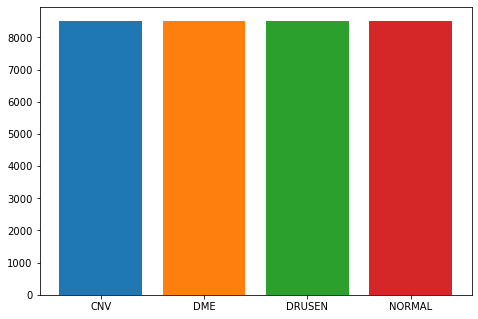

The size of  df_val_CNV  is (100, 2) 
The size of  df_val_DME  is (100, 2) 
The size of  df_val_DRUSEN  is (100, 2) 
The size of  df_val_NORMAL  is (100, 2) 


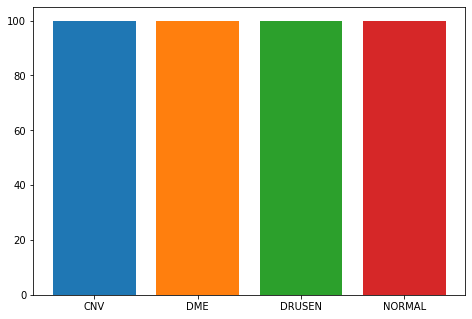

The size of  df_test_CNV  is (242, 2) 
The size of  df_test_DME  is (242, 2) 
The size of  df_test_DRUSEN  is (242, 2) 
The size of  df_test_NORMAL  is (242, 2) 


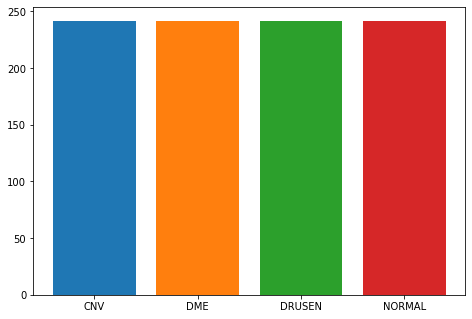

In [4]:
# Load data
def load_data(path, label, class_type):
    
    image_list = glob.glob(path + class_type + '/*')
    label_list = list(repeat(label, len(image_list)))
    
    data = list(zip(image_list,label_list))
    df = pd.DataFrame(data, columns = ['images', 'labels'])

    return df
        
# Plot class distribution
def plot_dataset_imbalance(sample_distribution): 
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(CLASSES, sample_distribution, color=COLORS)
    plt.show()
        
        
        
for dataset, path in list(zip(['train', 'val', 'test'], [train_dir, val_dir, test_dir])):
    for label,class_type in enumerate(CLASSES):
        df_var = "df_" + dataset + "_" + class_type
        vars()[df_var] = load_data(path, str(label), class_type)
        sample_size_var = "num_" + class_type
        vars()[sample_size_var] = vars()[df_var].shape[0]        
        print('The size of ', df_var, ' is {} '.format(vars()[df_var].shape))
    
    sample_distribution = [num_CNV, num_DME, num_DRUSEN, num_NORMAL]
    plot_dataset_imbalance(sample_distribution)

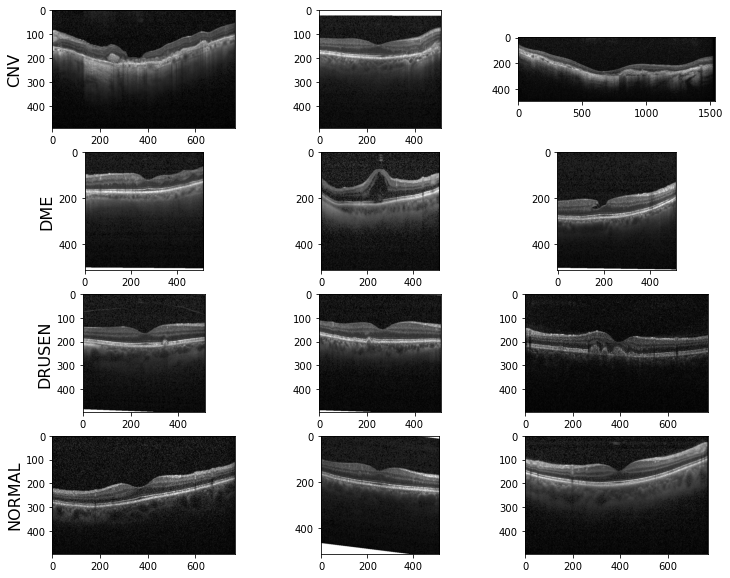

In [5]:
# Plot randomly selected images of each class
fig=plt.figure(figsize=(12, 10))
cols = 3
rows = 4

for idx, rand_idx in enumerate(np.random.randint(0,1000, size=cols*rows)):
    class_type = CLASSES[int(idx/cols)]
    df_var = "df_train_" + class_type
    img = vars()[df_var]['images'][rand_idx]
    img = plt.imread(img)
    ax = fig.add_subplot(rows, cols, idx+1)

    if idx%cols==0:
        plt.ylabel(CLASSES[int(idx/cols)], fontsize=16)
        
    plt.imshow(img, cmap='gist_gray')

In [6]:
# Get either original training set or oversampled training set
def get_train_set(upsample=0):
    
    if upsample == 0:
        df_train_upsample = pd.concat([df_train_CNV, 
                               df_train_DME,
                               df_train_DRUSEN,
                               df_train_NORMAL], axis=0).reset_index(drop=True)
    else:
        df_train_upsample = pd.concat([df_train_CNV, 
                               #df_train_DME,
                               #df_train_DRUSEN,
                               df_train_DME, df_train_DME, 
                               df_train_DRUSEN, df_train_DRUSEN, 
                               df_train_NORMAL], axis=0).reset_index(drop=True)

    # Shuffle with seed
    df_train = shuffle(df_train_upsample, random_state=42)
    print('The size of df_train is {}'.format(df_train.shape))
      
    return df_train

In [7]:
def get_test_set():
    
    df_test_combined = pd.concat([df_test_CNV, df_val_CNV, 
                                  df_test_DME, df_val_DME, 
                                  df_test_DRUSEN, df_val_DRUSEN,
                                  df_test_NORMAL, df_val_NORMAL], 
                                 axis=0).reset_index(drop=True)
    
    # Shuffle with seed
    df_test = shuffle(df_test_combined, random_state=42)
    print('The size of df_test is {}'.format(df_test.shape))

    return df_test

In [8]:
# Split the train set into a train/val set
def get_train_val_split_data(df_train, test_size=0.05):

    # Select the column that we will use for stratification
    y = df_train['labels']
    df_train, df_val = train_test_split(df_train, test_size=test_size, random_state=42, stratify=y)

    print('The size of df_train is {}'.format(df_train.shape))
    print('The size of df_val is {}'.format(df_val.shape))
    
    return df_train, df_val

In [9]:
# Plot pie chart of dataset distribution
def plot_dataset_distribution(df_train, df_test):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 6))

    for index,dataset in enumerate(['train', 'test']):
    
        df_var = "df_" + dataset 
        counts = vars()[df_var]['labels'].value_counts().sort_index()
        ax[index].pie(counts, labels=CLASSES, autopct='%.1f %%', colors=COLORS)
        ax[index].set_title( '{} set'.format(dataset))
    
    fig.suptitle('Class distribution for train and test datasets',
                 y=1.1, fontsize=16)
    fig.tight_layout()

In [10]:
def get_class_weights(verbose=1):
    
    counter = Counter(df_train.labels)                          
    max_count = float(max(counter.values()))  
    class_weights = {int(class_label) : max_count/num_images for class_label, 
                     num_images in counter.items()}                     
    if verbose:
        print('Class weights: \n', class_weights)
    return class_weights

In [11]:
# Generate batches for training set with our without data augmentation
def get_train_data(augmentation=0):
    
    # Data augmentation
    if augmentation:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)        
    else:    
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    # Generate batches
    train_data= train_datagen.flow_from_dataframe(dataframe=df_train, 
                                            directory=None,    # Paths specified in x_col
                                            x_col="images", 
                                            y_col="labels", 
                                            class_mode="categorical",  # For multiclass
                                            target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size=BATCH_SIZE)
    return train_data

In [12]:
# Generate batches for validation set
def get_valid_data():
    
    valid_datagen = ImageDataGenerator(rescale=1./255)
    valid_data = valid_datagen.flow_from_dataframe(dataframe=df_val, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= True,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=16)
    return valid_data

In [13]:
# Generate batches for test set
def get_test_data():
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(dataframe=df_test, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= False,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=16)
    return test_data

The size of df_train is (34096, 2)
The size of df_train is (32391, 2)
The size of df_val is (1705, 2)
The size of df_test is (1368, 2)
Found 32391 validated image filenames belonging to 4 classes.
Found 1705 validated image filenames belonging to 4 classes.
Found 1368 validated image filenames belonging to 4 classes.
Class weights: 
 {1: 1.0, 2: 1.0, 0: 1.0001235025318018, 3: 1.0}


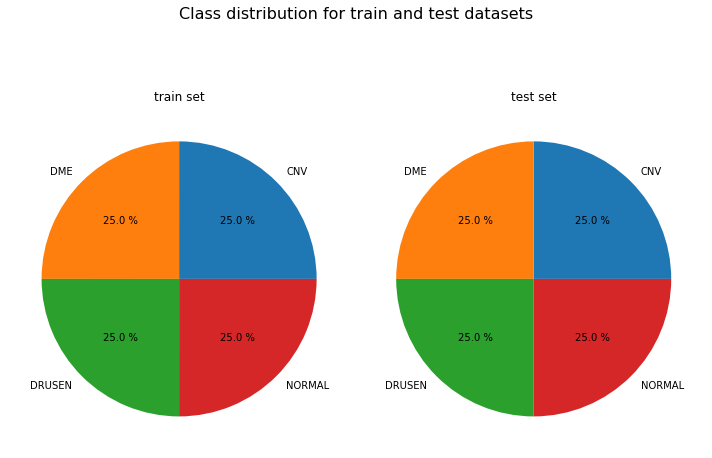

In [14]:
# Get different sets of data and generate batches
df_train = get_train_set(rebalance=0)
df_train, df_val = get_train_val_split_data(df_train)
df_test = get_test_set()

train_data = get_train_data(augmentation=1)
valid_data = get_valid_data()
test_data = get_test_data()

class_weights = get_class_weights()

plot_dataset_distribution(df_train, df_test) 

In [15]:
# Load model without top layers
vgg16 = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = INPUT_SHAPE, 
    pooling = None, 
    classes = 1000
)

# Freeze base
vgg16.trainable = False

In [16]:
# Add custom classifier on top of pretrained model
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [17]:
metrics_list = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.F1Score(num_classes = 4)]

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics_list)

In [19]:
history = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // BATCH_SIZE,
    epochs = 10,
    class_weight = class_weights, 
    validation_data = valid_data,
    validation_steps=valid_data.samples // 16,
    verbose = 1
)

Epoch 1/10
323/323 [==============================] - 259s 782ms/step - loss: 0.9992 - accuracy: 0.5665 - auc: 0.8133 - f1_score: 0.5624 - val_loss: 0.7248 - val_accuracy: 0.7176 - val_auc: 0.9139 - val_f1_score: 0.7143
Epoch 2/10
323/323 [==============================] - 247s 763ms/step - loss: 0.6932 - accuracy: 0.7258 - auc: 0.9170 - f1_score: 0.7247 - val_loss: 0.5721 - val_accuracy: 0.7871 - val_auc: 0.9430 - val_f1_score: 0.7843
Epoch 3/10
323/323 [==============================] - 247s 764ms/step - loss: 0.6348 - accuracy: 0.7507 - auc: 0.9304 - f1_score: 0.7495 - val_loss: 0.5252 - val_accuracy: 0.7972 - val_auc: 0.9521 - val_f1_score: 0.7951
Epoch 4/10
323/323 [==============================] - 246s 762ms/step - loss: 0.6116 - accuracy: 0.7595 - auc: 0.9354 - f1_score: 0.7588 - val_loss: 0.4953 - val_accuracy: 0.8143 - val_auc: 0.9570 - val_f1_score: 0.8121
Epoch 5/10
323/323 [==============================] - 247s 764ms/step - loss: 0.5818 - accuracy: 0.7740 - auc: 0.9415 - 

In [20]:
# Plots training and validation accuracy
def plot_curves(history, save_figure=True):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy' + ' | ' + FULL_NAME)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss' + ' | ' + FULL_NAME)
    plt.xlabel('Epoch')
    
    if save_figure:
        plt.savefig('../../img/' + MODEL + '/' + FULL_NAME + '.png',
            bbox_inches ="tight",
            transparent = True)
        
    plt.show()    

# Heatmap confusion matrix
def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          save_figure=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy  
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.title('Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass), fontsize=14)
    plt.suptitle(title, fontsize=16)
    plt.colorbar()

    thresh = cm.max() / 2.0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if save_figure:
        plt.savefig('../../img/' + MODEL + '/' + FULL_NAME + '_cm.png',
            bbox_inches ="tight",
            transparent = True)

In [21]:
# Evaluate model on test data
y_prob = model.predict(test_data, steps=len(test_data), verbose=1)
y_pred = np.argmax(y_prob,axis=1)
y_true = df_test['labels'].astype('int64').to_numpy()

86/86 [==============================] - 7s 86ms/step


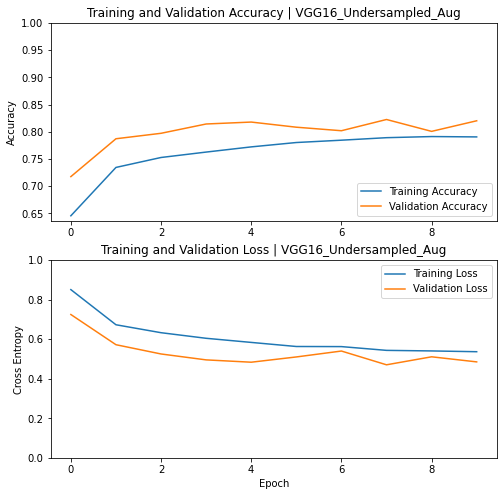

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       342
           1       0.96      0.86      0.91       342
           2       0.90      0.87      0.88       342
           3       0.84      0.98      0.91       342

    accuracy                           0.90      1368
   macro avg       0.91      0.90      0.90      1368
weighted avg       0.91      0.90      0.90      1368

The accuracy is 0.9042397660818714


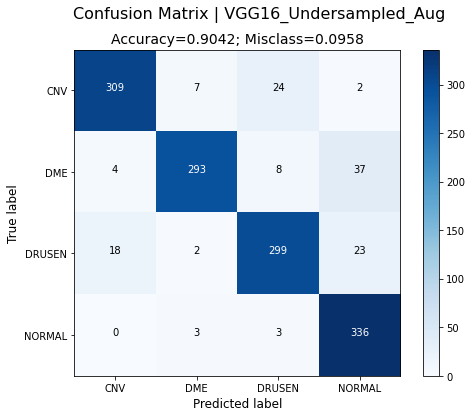

In [22]:
# Curves
plot_curves(history, save_figure=True)

# Confusion matrix
cm = confusion_matrix(y_true,y_pred)
classes = np.array(CLASSES)
title = 'Confusion Matrix' + ' | ' + FULL_NAME
plot_confusion_matrix(cm, classes, title, save_figure=True)

# Results
print(classification_report(y_true, y_pred))
print('The accuracy is {}'.format(accuracy_score(y_true, y_pred)))